### Install Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import json
import seaborn as sns
from numpy import asarray
from numpy import save
from numpy import load
import pickle
import joblib
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

# Datapreparation for models with time dependence

### Load combined and prepared time series data

In [3]:
cc4_data = pd.read_csv("../data/ts_data.csv") 

## Minutes a section needs to pass through the caster when casting speed is at the lowest 

In [4]:
data = cc4_data.drop('seq_id', axis=1)
combined_grouped = data.groupby(data['ChargenNrErsteSchmInSeq'])
grouped = combined_grouped['GiessGeschwInMproMin'].mean().to_frame()
length_cc4 = 15.42
min_v = np.round(grouped.min(),2)
seq_len = int(np.ceil(length_cc4 / min_v))
seq_len


50

## Define keys

In [5]:
interesting = ['DATE_TIME','ChargenNr','GiessBeginn_DateTime',
            'GiessEnde_DateTime','TempMittelLsInC','GiessLaengeSequenzInM',
    'TempMittelFsInC','ChargenNrErsteSchmInSeq','GiessLaengeSchmelzeInM','AusfLaengeSchmelzeInM','seq_id']

In [6]:
unwanted = ['DATE_TIME','TIME', 'ChargenNr', 'GiessBeginnSchmelze','GiessBeginn_DateTime',
            'GiessEndeSchmelze','GiessEnde_DateTime','EndeSchmelze','Ende_DateTime','NrSchmelzeInSequenz',
            
            'WasserZ1FsInLproMin','WasserZ1LsInLproMin', 'WasserZ2bFsInLproMin','WasserZ4FsInLproMin',
            'WasserZ4LsInLproMin','WasserZ3bLsInLproMin','WasserZ3bFsInLproMin','WasserZ1DiefflenInLproMin',
            'WasserZ2bLsInLproMin','WasserZ1DillingenInLproMin','WasserZ2aLsInLproMin','WasserZ2aFsInLproMin',
            'WasserZ5FsInLproMin','WasserZ5LsInLproMin','WasserZ3aFsInLproMin','WasserZ3aLsInLproMin',
            'GiessGeschwInMproMin',  
            'GiessGeschwInMproMin_integr','strang_nr','TempMittelLsInC_old','TempMittelFsInC_old',
            'WasserZ1DiefflenInLproMin_integr', 'WasserZ1DillingenInLproMin_integr',
            'GiessLaengeSchmelzeInM_delta', 'Format',
           ]    

In [7]:
cc4_keys = cc4_data.columns.to_list()
column_keys = [key for key in cc4_keys if key not in unwanted]
numeric_keys = column_keys.copy()
numeric_keys.remove('seq_id')
label_keys = ['TempMittelLsInC', 'TempMittelFsInC']
feature_keys = [key for key in numeric_keys if key not in label_keys]
feature_keys.remove('ChargenNrErsteSchmInSeq')
wanted_keys = label_keys + feature_keys

In [8]:
## save label and feature keys

# with open('../data/lstm_mlp/label_keys', 'wb') as fp:
#     pickle.dump(label_keys, fp)
# with open('../data/lstm_mlp/feature_keys', 'wb') as fp:
#     pickle.dump(feature_keys, fp)

##  Begin when first meter has reached the pyrometer

In [9]:
cc4_data = cc4_data[cc4_data['GiessLaengeSequenzInM']>length_cc4+1]  

## Duplicate data and give different sequence name in order to have different sequences for different sets

In [10]:
cc4_data_old = cc4_data.copy()
for i in range(1,11):
    cc4_data_1 = cc4_data_old.copy()
    cc4_data_1['ChargenNrErsteSchmInSeq'] = cc4_data_1['ChargenNrErsteSchmInSeq'] + i #new sequence with same values
    cc4_data_1['seq_id'] =  str(cc4_data_1['ChargenNrErsteSchmInSeq']) + '_str_' + str(cc4_data_1['strang_nr'])
    cc4_data = pd.concat([cc4_data, cc4_data_1])

# change sequences id 
def seq_and_str_nr(row):
    row['seq_id'] = str(row['ChargenNrErsteSchmInSeq']) + '_str_' + str(row['strang_nr'])
    return row

cc4_data = cc4_data.apply(seq_and_str_nr, axis=1)

## Drop unwanted columns

In [11]:
cc4_data = cc4_data.drop(unwanted, axis=1)

## create train-, validation- and test-set
### don't split inbetween a sequence

In [12]:
sequences = cc4_data.groupby('ChargenNrErsteSchmInSeq')
seq_keys = list(sequences.groups.keys())

train_full_keys, test_keys = train_test_split(seq_keys, test_size=0.25,random_state=42)
train_keys, valid_keys = train_test_split(train_full_keys, test_size=0.25, random_state=42)

In [13]:
## Save train, validation, test and all_train keys

# with open('../data/lstm_mlp/train_keys', 'wb') as fp:
#     pickle.dump(train_keys, fp)
# with open('../data/lstm_mlp/valid_keys', 'wb') as fp:
#     pickle.dump(valid_keys, fp)
# with open('../data/lstm_mlp/test_keys', 'wb') as fp:
#     pickle.dump(test_keys, fp)
# with open('../data/lstm_mlp/all_train_keys', 'wb') as fp:
#     pickle.dump(train_full_keys, fp)

In [14]:
def create_set(key_set,data):
    df = pd.DataFrame()
    for key in key_set:
        df2 = pd.DataFrame()
        df2 = data[data['ChargenNrErsteSchmInSeq']==key]
        df = pd.concat([df,df2],axis=0)
    return df

In [15]:
train_data = create_set(train_keys, cc4_data).reset_index(drop=True)
valid_data = create_set(valid_keys, cc4_data).reset_index(drop=True)
test_data = create_set(test_keys, cc4_data).reset_index(drop=True)
all_train_data = pd.concat([train_data, valid_data], axis=0).reset_index(drop=True)

[[]]

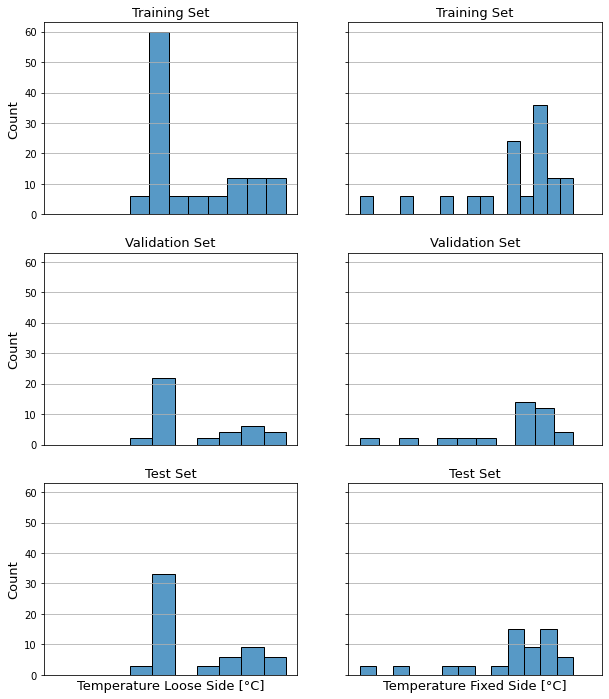

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(10,12),  sharex=True, sharey=True)

sns.histplot(ax=axes[0,0], data=train_data, x='TempMittelLsInC',color=sns.color_palette()[0])
sns.histplot(ax=axes[0,1], data=train_data, x='TempMittelFsInC',color=sns.color_palette()[0])
sns.histplot(ax=axes[1,0] ,data=valid_data, x='TempMittelLsInC',color=sns.color_palette()[0])
sns.histplot(ax=axes[1,1] ,data=valid_data, x='TempMittelFsInC',color=sns.color_palette()[0])
sns.histplot(ax=axes[2,0], data=test_data, x='TempMittelLsInC',color=sns.color_palette()[0] )
sns.histplot(ax=axes[2,1], data=test_data, x='TempMittelFsInC', color=sns.color_palette()[0])

axes[0,0].set_title('Training Set', fontdict={'fontsize':13} )
axes[0,0].set(xticks=[]) 
axes[0,0].set_xlabel('Temperature [°C]', fontsize=13)
axes[0,0].set_ylabel('Count', fontsize=13)
axes[0,0].yaxis.grid(True)
axes[0,0].set(xticks=[]) 

axes[0,1].set_title('Training Set', fontdict={'fontsize':13} )
axes[0,1].set(xticks=[]) 
axes[0,1].set_xlabel('Temperature [°C]', fontsize=13)
axes[0,1].set_ylabel('Count', fontsize=13)
axes[0,1].yaxis.grid(True)
axes[0,1].set(xticks=[]) 

axes[1,0].set_title('Validation Set', fontdict={'fontsize':13} )
axes[1,0].set(xticks=[]) 
axes[1,0].set_xlabel('Temperature [°C]', fontsize=13)
axes[1,0].set_ylabel('Count', fontsize=13)
axes[1,0].yaxis.grid(True)
axes[1,0].set(xticks=[]) 

axes[1,1].set_title('Validation Set', fontdict={'fontsize':13} )
axes[1,1].set(xticks=[]) 
axes[1,1].set_xlabel('Temperature [°C]', fontsize=13)
axes[1,1].set_ylabel('Count', fontsize=13)
axes[1,1].yaxis.grid(True)
axes[1,1].set(xticks=[]) 

axes[2,0].set_title('Test Set', fontdict={'fontsize':13} )
axes[2,0].set(xticks=[]) 
axes[2,0].set_xlabel('Temperature Loose Side [°C]', fontsize=13)
axes[2,0].set_ylabel('Count', fontsize=13)
axes[2,0].yaxis.grid(True)
axes[2,0].set(xticks=[]) 

axes[2,1].set_title('Test Set', fontdict={'fontsize':13} )
axes[2,1].set(xticks=[]) 
axes[2,1].set_xlabel('Temperature Fixed Side [°C]', fontsize=13)
axes[2,1].set_ylabel('Count', fontsize=13)
axes[2,1].yaxis.grid(True)
axes[2,1].set(xticks=[]) 





In [17]:
# train_data.to_pickle("../data/lstm_mlp/train_unsc_ts.pkl")
# valid_data.to_pickle("../data/lstm_mlp/valid_unsc_ts.pkl")
# test_data.to_pickle("../data/lstm_mlp/test_unsc_ts.pkl")
# all_train_data.to_pickle("../data/lstm_mlp/all_train_unsc_ts.pkl")

### Normalize data

In [18]:
#save ids since they are needed later
id_train = train_data['seq_id'].to_frame()
id_valid = valid_data['seq_id'].to_frame()
id_test = test_data['seq_id'].to_frame()
id_all_train = all_train_data['seq_id'].to_frame()

#train set and validation set
scaler_x_train = MinMaxScaler(feature_range=(0,1))
train_x = scaler_x_train.fit_transform(train_data[feature_keys])
df_train_x_norm = pd.DataFrame(train_x, columns=feature_keys)
valid_x = scaler_x_train.transform(valid_data[feature_keys])
df_valid_x_norm = pd.DataFrame(valid_x, columns=feature_keys)

scaler_y_train = MinMaxScaler(feature_range=(0,1))
train_y = scaler_y_train.fit_transform(train_data[label_keys])
df_train_y_norm = pd.DataFrame(train_y, columns=label_keys)
valid_y = scaler_y_train.transform(valid_data[label_keys])
df_valid_y_norm = pd.DataFrame(valid_y, columns=label_keys)

#all the training data
scaler_x = MinMaxScaler(feature_range=(0,1))
all_x = scaler_x.fit_transform(all_train_data[feature_keys])
df_all_x_norm = pd.DataFrame(all_x, columns=feature_keys)
test_x = scaler_x.transform(test_data[feature_keys])
df_test_x_norm = pd.DataFrame(test_x, columns=feature_keys)

scaler_y = MinMaxScaler(feature_range=(0,1))
all_y = scaler_y.fit_transform(all_train_data[label_keys])
df_all_y_norm = pd.DataFrame(all_y, columns=label_keys)
test_y = scaler_y.transform(test_data[label_keys])
df_test_y_norm = pd.DataFrame(test_y, columns=label_keys)

#create one dataframe
train_norm = pd.concat([df_train_y_norm, df_train_x_norm], axis=1)
valid_norm = pd.concat([df_valid_y_norm, df_valid_x_norm], axis=1)
test_norm = pd.concat([df_test_y_norm, df_test_x_norm], axis=1)
all_train_norm = pd.concat([df_all_y_norm, df_all_x_norm], axis=1)

#add the ids again
train_norm = pd.concat([train_norm,id_train],axis=1).reset_index(drop=True)
valid_norm = pd.concat([valid_norm,id_valid],axis=1).reset_index(drop=True)
test_norm = pd.concat([test_norm,id_test],axis=1).reset_index(drop=True)
all_train_norm = pd.concat([all_train_norm,id_all_train],axis=1).reset_index(drop=True)


### Save Scaler

In [19]:
# scaler_filename = "../data/lstm_mlp/scaler_all_train_y.save"
# joblib.dump(scaler_y, scaler_filename)

# scaler_filename = "../data/lstm_mlp/scaler_all_train_x.save"
# joblib.dump(scaler_x, scaler_filename)

# scaler_filename = "../data/lstm_mlp/scaler_train_valid_y.save"
# joblib.dump(scaler_y_train, scaler_filename)

# scaler_filename = "../data/lstm_mlp/scaler_train_valid_x.save"
# joblib.dump(scaler_x_train, scaler_filename)

### Save normalized data as pickle

In [20]:
# train_norm.to_pickle("../data/lstm_mlp/train_scaled.pkl")
# valid_norm.to_pickle("../data/lstm_mlp/valid_scaled.pkl")
# test_norm.to_pickle("../data/lstm_mlp/test_scaled.pkl")
# all_train_norm.to_pickle("../data/lstm_mlp/all_train_scaled.pkl")

## Data preparation for LSTM Models

### bring data in the right format
LSTM format: (samples, timesteps, features). Since we only have limited data, we only use 5 time steps for each sample and not 50 time steps as with the full data.

In [21]:
def lstm_format(data):
    seq_len = 5 ## only 5 time steps in for each prediction
    features = []
    labels = []
    data_set = {}

    for _, group in data.groupby('seq_id'):
        for i in range(len(group)-(seq_len-1)):
            features.append(group[feature_keys].iloc[i:i+seq_len].to_numpy())  
            labels.append(group[label_keys].iloc[i+(seq_len-1)].to_numpy())

    data_set['x'] = np.stack(features)
    data_set['y'] = np.stack(labels)
    return data_set

In [22]:
train_n = lstm_format(train_norm)
train_x_norm = train_n['x'].copy()
train_y_norm = train_n['y'].copy()

In [23]:
valid_n = lstm_format(valid_norm)
valid_x_norm = valid_n['x'].copy()
valid_y_norm = valid_n['y'].copy()

In [24]:
test_n = lstm_format(test_norm)
test_x_norm = test_n['x'].copy()
test_y_norm = test_n['y'].copy()

In [25]:
all_train_n = lstm_format(all_train_norm)
all_train_x_norm = all_train_n['x'].copy()
all_train_y_norm = all_train_n['y'].copy()

### Save data sets for LSTM

In [26]:
# save('../data/lstm_mlp/train_x_norm.npy', train_x_norm)
# save('../data/lstm_mlp/train_y_norm.npy', train_y_norm)
# save('../data/lstm_mlp/valid_x_norm.npy', valid_x_norm)
# save('../data/lstm_mlp/valid_y_norm.npy', valid_y_norm)
# save('../data/lstm_mlp/test_x_norm.npy', test_x_norm)
# save('../data/lstm_mlp/test_y_norm.npy', test_y_norm)
# save('../data/lstm_mlp/all_train_x_norm.npy', all_train_x_norm)
# save('../data/lstm_mlp/all_train_y_norm.npy', all_train_y_norm)